In [1]:
#!pip uninstall torch
!pip install torch==1.0.0
import torch

import torchgeometry as tgm
from torch.autograd import Variable

from landmarks import detect_landmark
import numpy as np
import matplotlib.pyplot as plt
import cv2
from perspective_projection_matrix import get_perspective, get_P
from pinhole_camera_model import facial_landmarks
from morphable_model import read_pca_model, get_face_point_cloud
from viewport_matrix import get_V

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


searching for scad in: /Users/nikitabortych/.pyenv/plugins/pyenv-virtualenv/shims:/Users/nikitabortych/.pyenv/shims:/Users/nikitabortych/.pyenv/bin:/Users/nikitabortych/.jenv/bin:/anaconda/bin:/Users/nikitabortych/anaconda/bin:/Users/nikitabortych/Evolutionary_Computing/VU-EC-Assignment:/Library/Frameworks/Python.framework/Versions/3.6/bin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/bin:/Library/TeX/texbin:/Applications/OpenSCAD.app/Contents/MacOS
/Users/nikitabortych/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [140]:
def get_face_point_cloud_torch(p, alpha, delta): ##TO TORCH
    """
    Get face point cloud for given alpha and delta.

    :param p: PCA model received with read_pca_model()
    :param alpha: size 30
    :param delta: size 20
    :return: 3D point cloud of size [num_points x 3]
    """
    G_id = torch.from_numpy(p["mu_id"]) + torch.from_numpy(p["E_id"]) @ ( torch.from_numpy(p["sigma_id"]) * alpha)
    G_ex = torch.from_numpy(p["mu_ex"]) + torch.from_numpy(p["E_ex"]) @ ( torch.from_numpy(p["sigma_ex"]) * delta)
    return (G_id+G_ex).view((-1, 3))



def get_rotation_matrix_torch(theta):
    """
    Get rotation matrix for angles theta = [theta_x, theta_y, theta_z].
    Theta is represented in degrees originally.
    """

    # transform from degree to radians
    theta =  [tgm.deg2rad(i) for i in theta]

    R_x = torch.tensor([[1, 0, 0],
                    [0, torch.cos(theta[0]), -torch.sin(theta[0])],
                    [0, torch.sin(theta[0]), torch.cos(theta[0])]])

    R_y = torch.tensor([[torch.cos(theta[1]), 0, torch.sin(theta[1])],
                    [0, 1, 0],
                    [-torch.sin(theta[1]), 0, torch.cos(theta[1])]])

    R_z = torch.tensor([[torch.cos(theta[2]), -torch.sin(theta[2]), 0],
                    [torch.sin(theta[2]), torch.cos(theta[2]), 0],
                    [0, 0, 1]])

    R = R_z @ R_y @ R_x

    return R


def facial_landmarks_torch(alpha, delta, w, t):
    """
    Construct facial landmarks from facial geometry latent parameters alpha, delta and object transformation w, t.

    :param alpha: array, 30dim
    :param delta: array, 20dim
    :param w: rotation angles around x,y, z. Given as list [theta_x, theta_y, theta_z].
    :param t: translation in x,y,z space. Given as list [translation_x, translation_y, translation_z]
    :return:
    """
    landmarks_idx = np.loadtxt("Landmarks68_model2017-1_face12_nomouth.anl", dtype=int)

    pca = read_pca_model()
    G = get_face_point_cloud_torch(pca, alpha, delta)[landmarks_idx].t()
    G_h = [G , torch.ones(G.shape[1]).view((1, -1))]
    G_h = torch.cat(G_h, dim=0)
    
    # get T matrix
    T = torch.eye(4)
    T[:3, :3] =get_rotation_matrix_torch(w) 
    T[:3, 3] = t

    # Get V and P matrices
    W = 255
    H = 255

    image_aspect_ratio = W / H
    angle = 10
    near = 300
    far = 2000

    right, left, top, bottom = get_perspective(image_aspect_ratio, angle, near, far)
    
    V = get_V(right, left, top, bottom)

    P = get_P(near, far, right, left, top, bottom)
    [V, P] = list(map(torch.from_numpy, [V, P]))
    V,P = V.to(dtype = torch.float32), P.to(dtype = torch.float32)
    n,f, t, b = near, far, top, bottom
    #P = torch.Tensor([[(2 * n) / (t-b), 0, 0, 0],
     #           [0, (2 * n) / (t - b), 0, 0],
      #        [0, 0, -(f + n) / (f - n), -(2 * f * n) / (f - n)],
       #       [0, 0, -1, 0]])
    i =  V @ P @ T @ G_h

    # homo to cartesian
    i = i/i[3,:].clone()

    # two-dimensional
    return i[:2, :].t()



def normalise(landmarks, is_ground = False, values =None):
    
        
    max_x = torch.max(landmarks[:,0].detach())
    max_y = torch.max(landmarks[:,1].detach())
    min_x = torch.min(landmarks[:,0].detach())
    min_y = torch.min(landmarks[:,1].detach())
   
    
    length=torch.sqrt((max_x-min_x).pow(2) + (max_y-min_y).pow(2))
    
    if values!=None:
        length, min_x, min_y = values
    landmarks[:,0] = (landmarks[:,0] - min_x)/length 
    landmarks[:,1] = (landmarks[:,1] - min_y)/length
    if is_ground:
        return landmarks, [length, min_x, min_y]
    return landmarks
    

0 8.585977554321289
20 1.374616265296936
40 0.8771731853485107
60 0.661455512046814
80 0.5674055218696594
100 0.5071775317192078
120 0.4830459952354431
140 0.4643767476081848
160 0.4528677463531494
180 0.44564390182495117


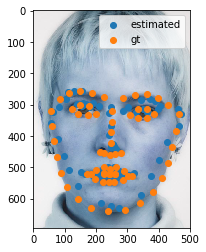

In [144]:
#initialise variables to optimise
alpha = Variable(torch.zeros(30), requires_grad=True)
delta = Variable(torch.zeros(20), requires_grad=True)
w = Variable(torch.tensor([np.pi, 0.0, 0.0]), requires_grad=True)
t = Variable(torch.tensor([0.0,0.0,-500.0]), requires_grad=True)
#read an image
image = cv2.imread('in.png')
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#get ground truth landmarks
target = torch.from_numpy(detect_landmark(img)).to(dtype = torch.float)
target, values = normalise(target, is_ground=True)
#set optimisation parameters
lr = 1
opt = torch.optim.Adam([alpha, delta, w, t], lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.5)
lambda_alpha = 0.0001
lambda_delta = 0.0001
#iterate
for i in range(200):
    
    if i % 50 == 0:
        scheduler.step()
        
    
    opt.zero_grad()
    #get predicted landmarks
    prediction_landmarks = facial_landmarks_torch(alpha, delta, w, t)
    prediction_landmarks = normalise(prediction_landmarks)
    
    
    target, values = normalise(target, is_ground = True)
    
    #compute loss
    loss_lan = torch.sum(torch.norm((prediction_landmarks-target)).pow(2))
    loss_reg = lambda_alpha * (alpha.pow(2)).sum() + lambda_delta * (delta.pow(2)).sum()
    loss = loss_lan + loss_reg
    #backprop
    if i%20==0:
        print(i, loss.item())
    loss.backward()
    opt.step()
#compute final landmarks


target = torch.from_numpy(detect_landmark(img)).to(dtype = torch.float)
target, values = normalise(target, is_ground = True)
target[:,0] = target[:,0]*values[0]+values[1]
target[:,1] = target[:,1]*values[0]+values[2]
target= target.detach().numpy()


test = facial_landmarks_torch(alpha, delta, w, t)#.detach().numpy()
test = normalise(test)
test[:,0] = test[:,0]*values[0]+values[1]
test[:,1] = test[:,1]*values[0]+values[2]
test = test.detach().numpy()

plt.imshow(image)
plt.scatter(test[:,0], test[:,1], label = "estimated")
plt.scatter(target[:,0], target[:,1], label = "gt")
plt.legend()
plt.show()

In [102]:
np.save("params2.npy", np.array([alpha, delta, w, t]))

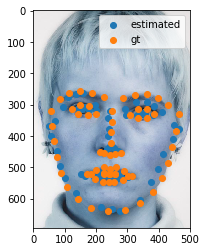

In [139]:
target = torch.from_numpy(detect_landmark(img)).to(dtype = torch.float)
target, values = normalise(target, is_ground = True)
target[:,0] = target[:,0]*values[0]+values[1]
target[:,1] = target[:,1]*values[0]+values[2]
target= target.detach().numpy()


test  = facial_landmarks_torch(alpha, delta, w, t)#.detach().numpy()
test = normalise(test)
test[:,0] = test[:,0]*values[0]+values[1]
test[:,1] = test[:,1]*values[0]+values[2]
test = test.detach().numpy()

image = cv2.imread('in.png')
plt.imshow(image)
plt.scatter(test[:,0], test[:,1], label = "estimated")
plt.scatter(target[:,0], target[:,1], label = "gt")
plt.legend()
plt.show()

In [ ]:
#for (x, y) in test:
 #   cv2.circle(image, (int(np.round(x)), int(np.round(y))), 2, (255, 0, 0), -1)



#for (x, y) in target:
 #   cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

#cv2.imshow("Output", image)
#cv2.waitKey(0)